# Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import session_info

In [2]:
try:
    session_info_output = session_info.show()
except Exception as error:
    print("The session info has been requested already:")
    
session_info_output

In [3]:
import janitor # This library generates an error when I execute session_info()

# Import external files

- Extension of the "missing" functions from Pandas
- DataFrame and dictionary functions
- Statistical functions

In [4]:
%run utils/u.0.0-pandas_missing_extension.ipynb
%run utils/u.0.1-df_functions.ipynb
%run utils/u.0.2-statistical-functions.ipynb

/home/ubuntu/anaconda3/lib/python3.11/site-packages/upsetplot/plotting.py:15: MatplotlibDeprecationWarning: The matplotlib.tight_layout module was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  from matplotlib.tight_layout import get_renderer


# Get the processed data

In [5]:
arg_di_df = pd.read_csv('../data/processed/WDICSV_PROCESSED.csv').clean_names(case_type="snake")

print(arg_di_df.shape)
arg_di_df.info()

(54, 28)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    54 non-null     int64  
 1   it_mlt_main             54 non-null     float64
 2   ny_gdp_mktp_kd_zg       54 non-null     float64
 3   ny_gdp_pcap_kd          54 non-null     float64
 4   ny_gdp_pcap_kd_zg       54 non-null     float64
 5   sp_dyn_le00_in          53 non-null     float64
 6   it_cel_sets             50 non-null     float64
 7   sh_dth_imrt             53 non-null     float64
 8   sp_pop_0014_to_zs       54 non-null     float64
 9   sp_pop_1564_to_zs       54 non-null     float64
 10  sp_pop_65_up_to_zs      54 non-null     float64
 11  sp_pop_totl             54 non-null     float64
 12  sm_pop_refg             54 non-null     float64
 13  sm_pop_refg_or          44 non-null     float64
 14  se_pre_enrr             45 non-null

# Get columns names and types

In [6]:
indicators_names, categorical_cols, numeric_cols, columns_with_missing_values = get_columns(arg_di_df)

In [7]:
print(f'Total Columns: {len(indicators_names)}')
print(f'Categorical Columns: {len(categorical_cols)}')
print(f'Numeric Columns: {len(numeric_cols)}')

Total Columns: 28
Categorical Columns: 6
Numeric Columns: 22


In [8]:
indicators_names

['year, Year',
 'it_mlt_main, Fixed telephone subscriptions',
 'ny_gdp_mktp_kd_zg, GDP growth (annual %)',
 'ny_gdp_pcap_kd, GDP per capita (constant 2015 US$)',
 'ny_gdp_pcap_kd_zg, GDP per capita growth (annual %)',
 'sp_dyn_le00_in, Life expectancy at birth, total (years)',
 'it_cel_sets, Mobile cellular subscriptions',
 'sh_dth_imrt, Number of infant deaths',
 'sp_pop_0014_to_zs, Population ages 0-14 (% of total population)',
 'sp_pop_1564_to_zs, Population ages 15-64 (% of total population)',
 'sp_pop_65_up_to_zs, Population ages 65 and above (% of total population)',
 'sp_pop_totl, Population, total',
 'sm_pop_refg, Refugee population by country or territory of asylum',
 'sm_pop_refg_or, Refugee population by country or territory of origin',
 'se_pre_enrr, School enrollment, preprimary (% gross)',
 'se_prm_enrr, School enrollment, primary (% gross)',
 'se_sec_enrr, School enrollment, secondary (% gross)',
 'se_ter_enrr, School enrollment, tertiary (% gross)',
 'sp_urb_totl_in_zs,

In [9]:
name_of_cols = ([get_indicator_name(item,True) for item in columns_with_missing_values])
name_of_cols

['School enrollment, tertiary (% gross)',
 'Refugee population by country or territory of origin',
 'School enrollment, preprimary (% gross)',
 'School enrollment, primary (% gross)',
 'School enrollment, secondary (% gross)',
 'Mobile cellular subscriptions',
 'Mobile Subscription (% of total population)',
 'Life expectancy at birth, total (years)',
 'Number of infant deaths']

# Shadow matrix

In [10]:
shadow_matrix = arg_di_df.missing.bind_shadow_matrix(only_missing = True, true_string=True, false_string=False)
shadow_matrix.head()

,year,it_mlt_main,ny_gdp_mktp_kd_zg,ny_gdp_pcap_kd,ny_gdp_pcap_kd_zg,sp_dyn_le00_in,it_cel_sets,sh_dth_imrt,sp_pop_0014_to_zs,sp_pop_1564_to_zs,...,ny_gdp_mktp_kd_grw_cat,sp_dyn_le00_in_NA,it_cel_sets_NA,sh_dth_imrt_NA,sm_pop_refg_or_NA,se_pre_enrr_NA,se_prm_enrr_NA,se_sec_enrr_NA,se_ter_enrr_NA,it_cel_sets_pct_NA
0,1970,1287000.0,3.045643,9257.895572,1.443200,65.589,0.0,32198.0,29.717264,63.733577,...,Unknown,False,False,False,True,False,False,False,False,False
1,1971,1287000.0,5.658131,9628.037838,3.998125,65.541,NaN,32685.0,29.656449,63.671716,...,Unknown,False,True,False,True,False,False,False,False,True
2,1972,1287000.0,1.628417,9630.010366,0.020487,65.923,NaN,33079.0,29.630850,63.584961,...,Medium volatility,False,True,False,True,False,False,False,False,True
3,1973,1287000.0,2.811754,9739.416271,1.136093,66.323,NaN,33442.0,29.652649,63.453990,...,Low volatility,False,True,False,True,False,False,False,False,True
4,1974,1287000.0,5.533804,10105.049508,3.754160,66.563,NaN,33629.0,29.739299,63.260447,...,Low volatility,False,True,False,True,False,False,False,False,True


# Data imputation

## Missing values visualization

Figure saved to: ../reports/figures/imputation/School enrollment, tertiary (% gross).png
Figure saved to: ../reports/figures/imputation/Refugee population by country or territory of origin.png
Figure saved to: ../reports/figures/imputation/School enrollment, preprimary (% gross).png
Figure saved to: ../reports/figures/imputation/School enrollment, primary (% gross).png
Figure saved to: ../reports/figures/imputation/School enrollment, secondary (% gross).png
Figure saved to: ../reports/figures/imputation/Mobile cellular subscriptions.png
Figure saved to: ../reports/figures/imputation/Mobile Subscription (% of total population).png
Figure saved to: ../reports/figures/imputation/Life expectancy at birth, total (years).png
Figure saved to: ../reports/figures/imputation/Number of infant deaths.png


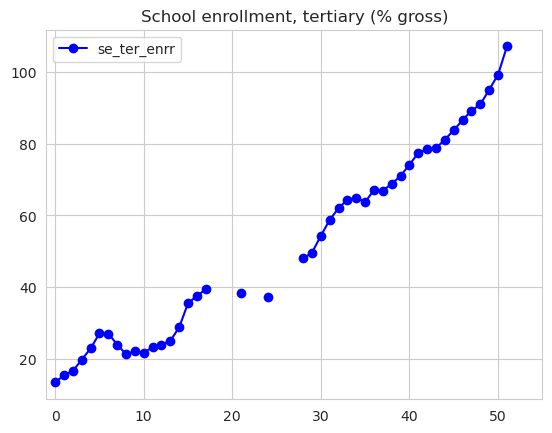

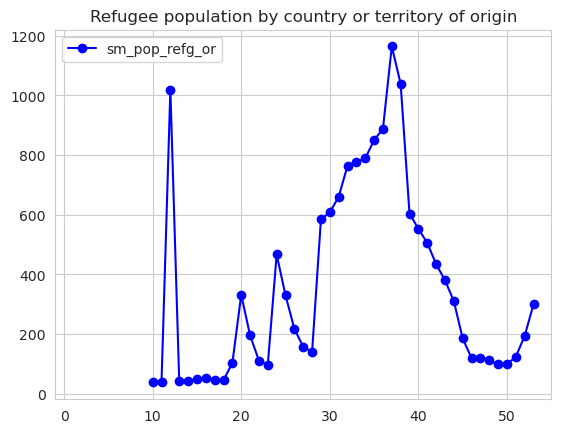

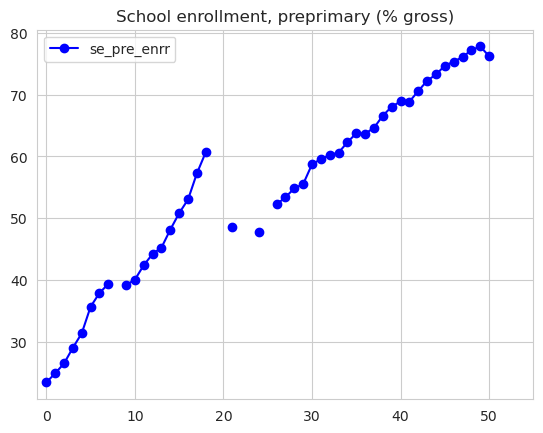

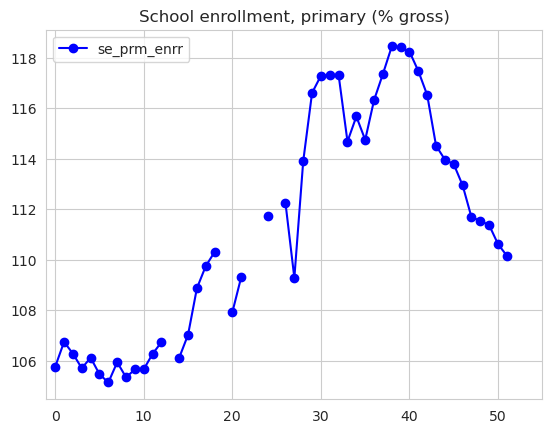

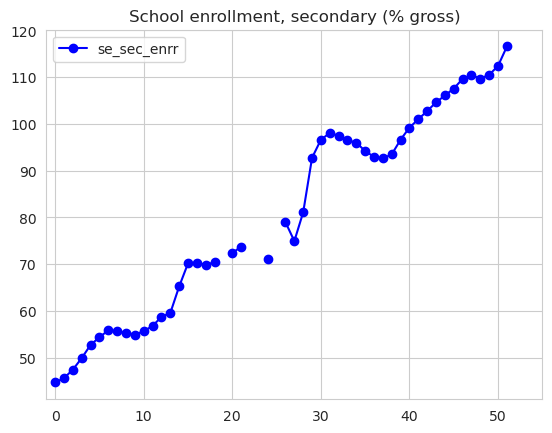

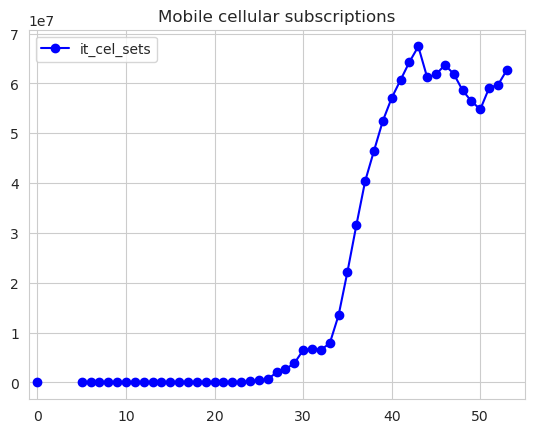

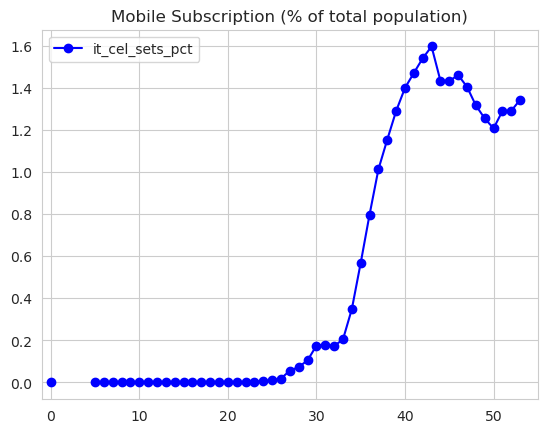

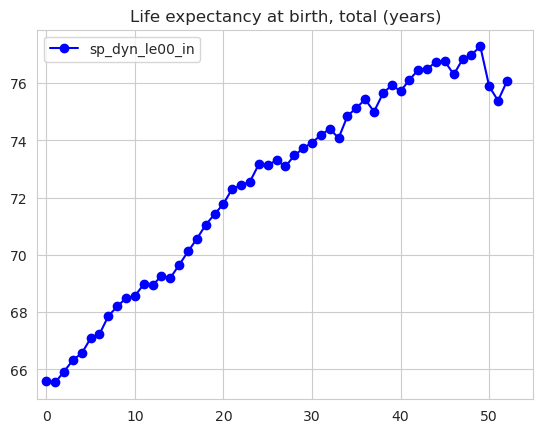

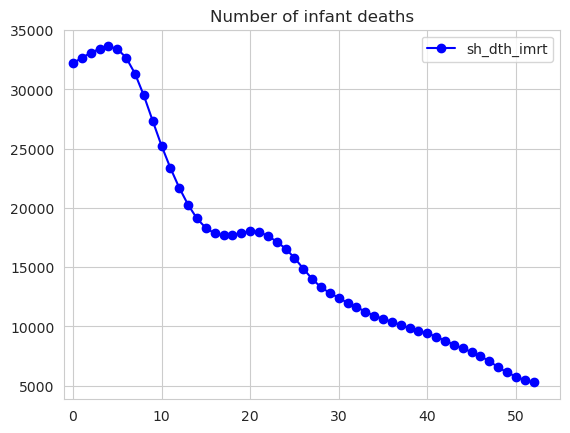

In [11]:
for i, col in enumerate(columns_with_missing_values):
    arg_di_df[[col]].plot(color="blue",marker="o",xlim=(-1,55))
    title = get_indicator_name(col,True)
    plt.title(title)
    save_figure(title, subfolder="imputation")

## Simple imputations

I use Google Colab to explore the different imputation methods to apply to each variable.

https://colab.research.google.com/drive/1IUKdZK-5SoLQoq9GxUjjGkFX-H-T25nb?usp=sharing

### Variables that I will impute with ffill

#### Mobile cellular subscriptions (it_cel_sets and it_cel_sets_pct)

In [12]:
print(f"Quantity of missing values in {get_indicator_name('it_cel_sets',True)}: {arg_di_df['it_cel_sets'].isna().sum()}")

Quantity of missing values in Mobile cellular subscriptions: 4


In [13]:
arg_di_df[['year','it_cel_sets','it_cel_sets_pct']].head(6)

,year,it_cel_sets,it_cel_sets_pct
0,1970,0.0,0.0
1,1971,NaN,NaN
2,1972,NaN,NaN
3,1973,NaN,NaN
4,1974,NaN,NaN
5,1975,0.0,0.0


In [14]:
arg_di_df['it_cel_sets'] = arg_di_df['it_cel_sets'].ffill()
arg_di_df['it_cel_sets_pct'] = arg_di_df['it_cel_sets_pct'].ffill()
arg_di_df[['year','it_cel_sets','it_cel_sets_pct']].head(6)

,year,it_cel_sets,it_cel_sets_pct
0,1970,0.0,0.0
1,1971,0.0,0.0
2,1972,0.0,0.0
3,1973,0.0,0.0
4,1974,0.0,0.0
5,1975,0.0,0.0


### Variables that i won't impute

#### Life expectancy at birth, total (years) and Number of infant deaths

- sh_dth_imrt
- sp_dyn_le00_in


Because the missing value is the last row.
And sp_dyn_le00_in will be the target value

In [15]:
arg_di_df[["year","sh_dth_imrt"]].tail(3)

,year,sh_dth_imrt
51,2021,5461.0
52,2022,5268.0
53,2023,NaN


In [16]:
arg_di_df[["year","sp_dyn_le00_in"]].tail(3)

,year,sp_dyn_le00_in
51,2021,75.390
52,2022,76.064
53,2023,NaN


#### Refugee population by country or territory of origin (sm_pop_refg_or)

Because the missing values are the first rows:

In [17]:
arg_di_df.loc[:10][["year","sm_pop_refg_or"]]

,year,sm_pop_refg_or
0,1970,NaN
1,1971,NaN
2,1972,NaN
3,1973,NaN
4,1974,NaN
5,1975,NaN
6,1976,NaN
7,1977,NaN
8,1978,NaN
9,1979,NaN


#### School enrollment

- se_pre_enrr
- se_prm_enrr
- se_sec_enrr
- se_ter_enrr

Because the variables don't show a clear trend:

Figure saved to: ../reports/figures/imputation/Enrollment by level (% Gross).png


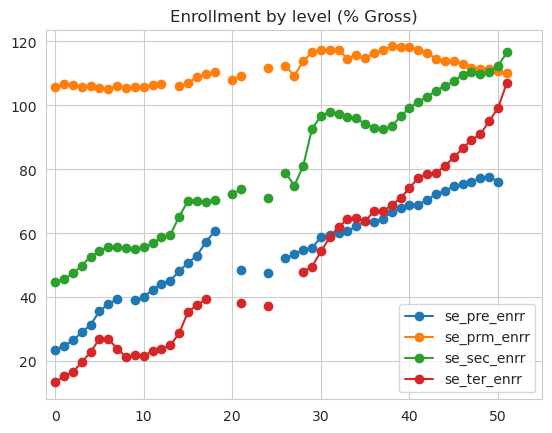

In [18]:
arg_di_df[["se_pre_enrr","se_prm_enrr","se_sec_enrr","se_ter_enrr"]].plot(marker="o",xlim=(-1,55))
title = "Enrollment by level (% Gross)"
plt.title(title)
save_figure(title, subfolder="imputation")

# Save the processed data (V2)

In [19]:
arg_di_df.to_csv('../data/processed/WDICSV_PROCESSED_V2.csv', index=False)